In [22]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import fsps
import emcee

% matplotlib inline

## Part (a) -- Integrated V and I magnitudes from `python-fsps`

In [58]:
### best-fit parameters from problem 1
DM = 14.65 # distance modulus
ai = 0.034 # extinction in I band from NED
av = 0.061 # extinction in V band from NED
feh = -2.25 # metallicity
logage = 10.15 # log_10 age 

We'll start by generating $V$ and $I$ Vega magnitudes for a SSP with parameters given by the above values. Everything that doesn't involve these parameters will be kept at the default values.

From reading the `fsps` documentation, it seems like I'd have to go into the fortran files and change something to use different isochrones and/or stellar libraries and I don't really want to mess with fortran code and just break all the code and not be able to get it to work again in useful time, so I'm just going to go with the default values for stellar evolution and stellar atmosphere models, which are the BaSeL stellar library and the Padova isochrones.

In [206]:
sp = fsps.StellarPopulation(compute_vega_mags=True, sfh=0, zcontinuous=1, logzsol=-2.25) # default sfh=0 corresponds to a SSP

In [207]:
vimags = sp.get_mags(tage=10**(10.15-9.0), bands=['v', 'cousins_i'])

In [208]:
v_true = vimags[0] + av + DM
i_true = vimags[1] + ai + DM
print v_true, i_true

21.0048050376 20.1560214927


## Part (b) &mdash; emcee parameter estimation assuming 1-$\sigma$ uncertainties of 0.1 mag

In [209]:
### add noise to photometry
v_err = np.random.normal(loc=0, scale=0.1)
i_err = np.random.normal(loc=0, scale=0.1)
v_data = v_true + v_err
i_data = i_true + i_err
print v_data, i_data

20.9386258393 20.2035082061


We're going to assume priors similar to those used for Problem 1. We already know the cluster is old and metal-poor and used this when generating our mock photometry, so let's say $\log$(age) between 10.0 and 10.25, $A_V$ extinction between 0.05 and 0.07, $A_I$ extinction between 0.025 and 0.045, distance modulus between 14.5 and 14.7 and metallicity between -2.50 and -2.00.

In [216]:
### set up emcee here
# probabilites here
def lnlike(theta, v_data, i_data, err):
    # assumes model SSP already defined in the variable mod_sp
    logage, met, DM, av, ai = theta
    mod_sp.params['logzsol'] = met
    vi_mod = mod_sp.get_mags(tage=10**(logage-9.), bands=['v', 'cousins_i'])
    v_mod = vi_mod[0] + av + DM
    i_mod = vi_mod[1] + ai + DM
    return -0.5*((v_data-v_mod)**2/err**2 + np.log(err**2) + \
                 (i_data-i_mod)**2/err**2 + np.log(err**2))

def lnprior(theta):
    logage, met, DM, av, ai = theta
    if 10.0 <= logage <= 10.25 and 14.5 <= DM <= 14.7 and 0.05 <= av <= 0.07 and 0.025 <= ai <= 0.045 and \
    -2.50 <= met <= -2.00:
        return 0.0
    return -np.inf

def lnprob(theta, v_data, i_data, err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, v_data, i_data, err)

In [211]:
### create an FSPS object
mod_sp = fsps.StellarPopulation(compute_vega_mags=True, sfh=0, zcontinuous=1, logzsol=-2.25)

In [212]:
### run emcee here
ndim, nwalkers = 5, 50
pos = [np.random.normal((10.1, -2.3, 14.6, 0.06, 0.03),(0.2,0.2,0.2,0.02, 0.02)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[v_data, i_data, 0.1])
pos1, prob, state = sampler.run_mcmc(pos, 200);
sampler.reset()
sampler.run_mcmc(pos1, 1000, rstate0=state);

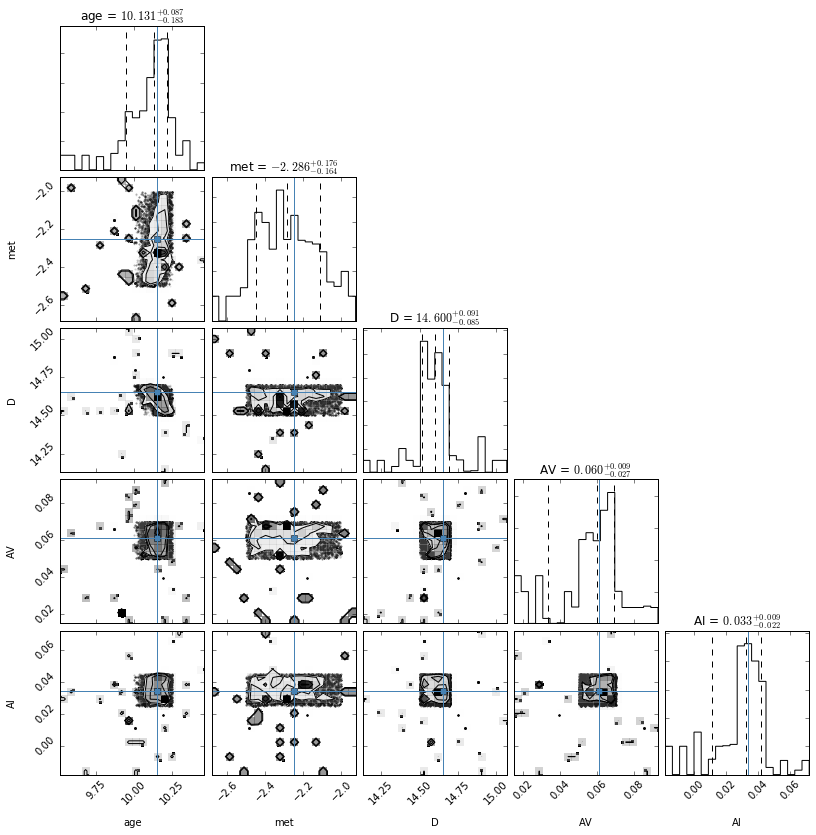

In [213]:
### plots here
emcee_samples = sampler.chain[:,:, :].reshape((-1, ndim))
fig = corner.corner(emcee_samples, labels=["age", "met", "D", "AV", "AI"], quantiles=[0.16, 0.5, 0.84], \
                    truths=[10.15, -2.25, 14.65, 0.061, 0.034], show_titles=True, title_fmt='.3f')
plt.show(fig)

As can be seen from the triangle plots, all parameters are within 1-$\sigma$ of the true value, but the uncertainties are fairly large. For example, age is between 9 and 16 Gyr. So, while the parameters are constrained, I can't say that they are particularly well constrained. A bit better constrained are distance and extinction. Out of all of the parameters, metallicity if the most poorly constrained one.

## Part (c) &mdash; same as part (b), but with uncertainties of 0.01

In [214]:
### add noise to photometry
v_err = np.random.normal(loc=0, scale=0.01)
i_err = np.random.normal(loc=0, scale=0.01)
v_data = v_true + v_err
i_data = i_true + i_err
print v_data, i_data

21.0060403225 20.1529112554


In [217]:
### run emcee here
ndim, nwalkers = 5, 50
pos = [np.random.normal((10.1, -2.3, 14.6, 0.06, 0.03),(0.2,0.2,0.2,0.02,0.02)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[v_data, i_data, 0.01])
pos1, prob, state = sampler.run_mcmc(pos, 200);
sampler.reset()
sampler.run_mcmc(pos1, 1200, rstate0=state);

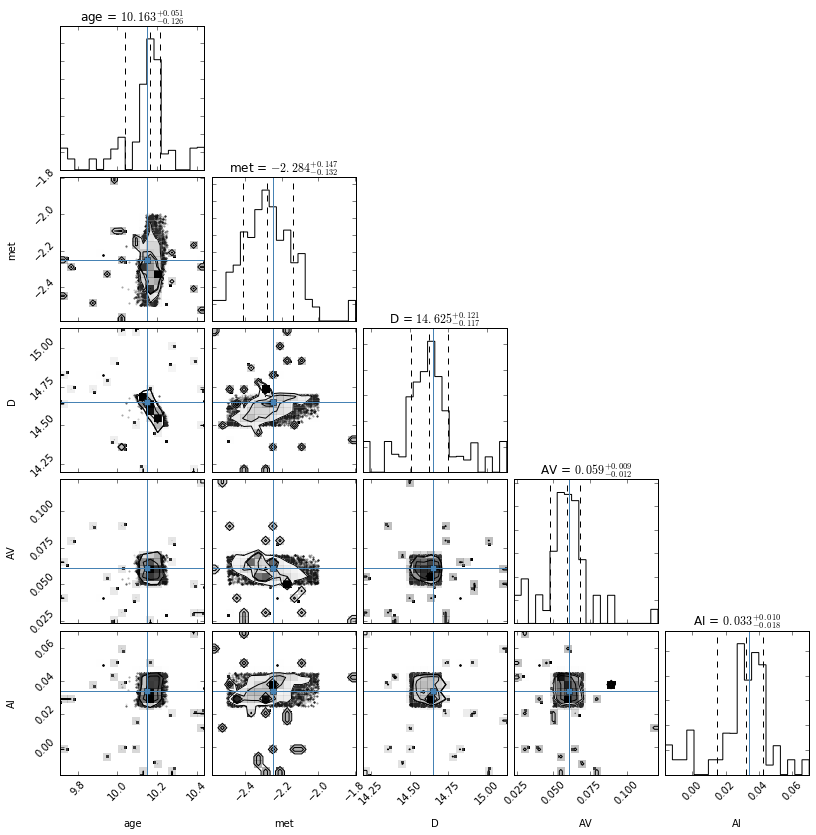

In [218]:
### plots here
emcee_samples = sampler.chain[:,:,:].reshape((-1, ndim))
fig = corner.corner(emcee_samples, labels=["age", "met", "D", "AV", "AI"], quantiles=[0.16, 0.5, 0.84], \
                    truths=[10.15, -2.25, 14.65, 0.061, 0.034], show_titles=True, title_fmt='.3f')
plt.show(fig)

With smaller uncertainties, it seems that all parameters are about as constrained or better than before. In particular, age and metallicity are a bit better constrained than before. 

## Part (d) &mdash; UBVI photometry

In [219]:
### U and B extinction from NED
au = 0.096 
ab = 0.081

In [220]:
sp = fsps.StellarPopulation(compute_vega_mags=True, sfh=0, zcontinuous=1, logzsol=-2.25) # default sfh=0 corresponds to a SSP
ubvimags = sp.get_mags(tage=10**(10.15-9.0), bands=['u', 'b', 'v', 'cousins_i'])

In [221]:
u_true = ubvimags[0] + au + DM
b_true = ubvimags[1] + ab + DM
v_true = ubvimags[2] + av + DM
i_true = ubvimags[3] + ai + DM
print u_true, b_true, v_true, i_true

21.481994324 21.5231443131 21.0048050376 20.1560214927


In [222]:
### add noise to photometry
u_err = np.random.normal(loc=0, scale=0.1)
b_err = np.random.normal(loc=0, scale=0.1)
v_err = np.random.normal(loc=0, scale=0.1)
i_err = np.random.normal(loc=0, scale=0.1)
u_data = u_true + u_err
b_data = b_true + b_err
v_data = v_true + v_err
i_data = i_true + i_err
print u_data, b_data, v_data, i_data

21.5661072217 21.4808770057 20.9842774659 20.2438184461


Old priors are going to be the same as before, new priors will be those on $A_U$ and $A_B$, which will be some interval of width 0.02 centered around the true values.

In [223]:
### set up emcee here
# probabilites here
def lnlike(theta, u_data, b_data, v_data, i_data, err):
    # assumes model SSP already defined in the variable mod_sp
    logage, met, DM, au, ab, av, ai = theta
    mod_sp.params['logzsol'] = met
    ubvi_mod = mod_sp.get_mags(tage=10**(logage-9.0), bands=['u', 'b', 'v', 'cousins_i'])
    u_mod = ubvi_mod[0] + au + DM
    b_mod = ubvi_mod[1] + ab + DM
    v_mod = ubvi_mod[2] + av + DM
    i_mod = ubvi_mod[3] + ai + DM
    return -0.5*((v_data-v_mod)**2/err**2 + np.log(err**2) + \
                 (i_data-i_mod)**2/err**2 + np.log(err**2) + \
                (u_data-u_mod)**2/err**2 + np.log(err**2) + \
                (b_data-b_mod)**2/err**2 + np.log(err**2))

def lnprior(theta):
    logage, met, DM, au, ab, av, ai = theta
    if 10.0 <= logage <= 10.25 and 14.5 <= DM <= 14.7 and 0.05 <= av <= 0.07 and 0.025 <= ai <= 0.045 and \
    0.085<= au <= 0.15 and 0.07 <= ab <= 0.09 and -2.50 <= met <= -2.00:
        return 0.0
    return -np.inf

def lnprob(theta, u_data, b_data, v_data, i_data, err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, u_data, b_data, v_data, i_data, err)

In [224]:
### create an FSPS object
mod_sp = fsps.StellarPopulation(compute_vega_mags=True, sfh=0, zcontinuous=1, logzsol=-2.25)

In [227]:
### run emcee here
ndim, nwalkers = 7, 70
pos = [np.random.normal((10.1, -2.3, 14.6, 0.09, 0.08, 0.06, 0.03),(0.2,0.2,0.2,0.02,0.02,0.02,0.02)) \
       for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[u_data, b_data, v_data, i_data, 0.1])
pos1, prob, state = sampler.run_mcmc(pos, 200);
sampler.reset()
sampler.run_mcmc(pos1, 2000, rstate0=state);

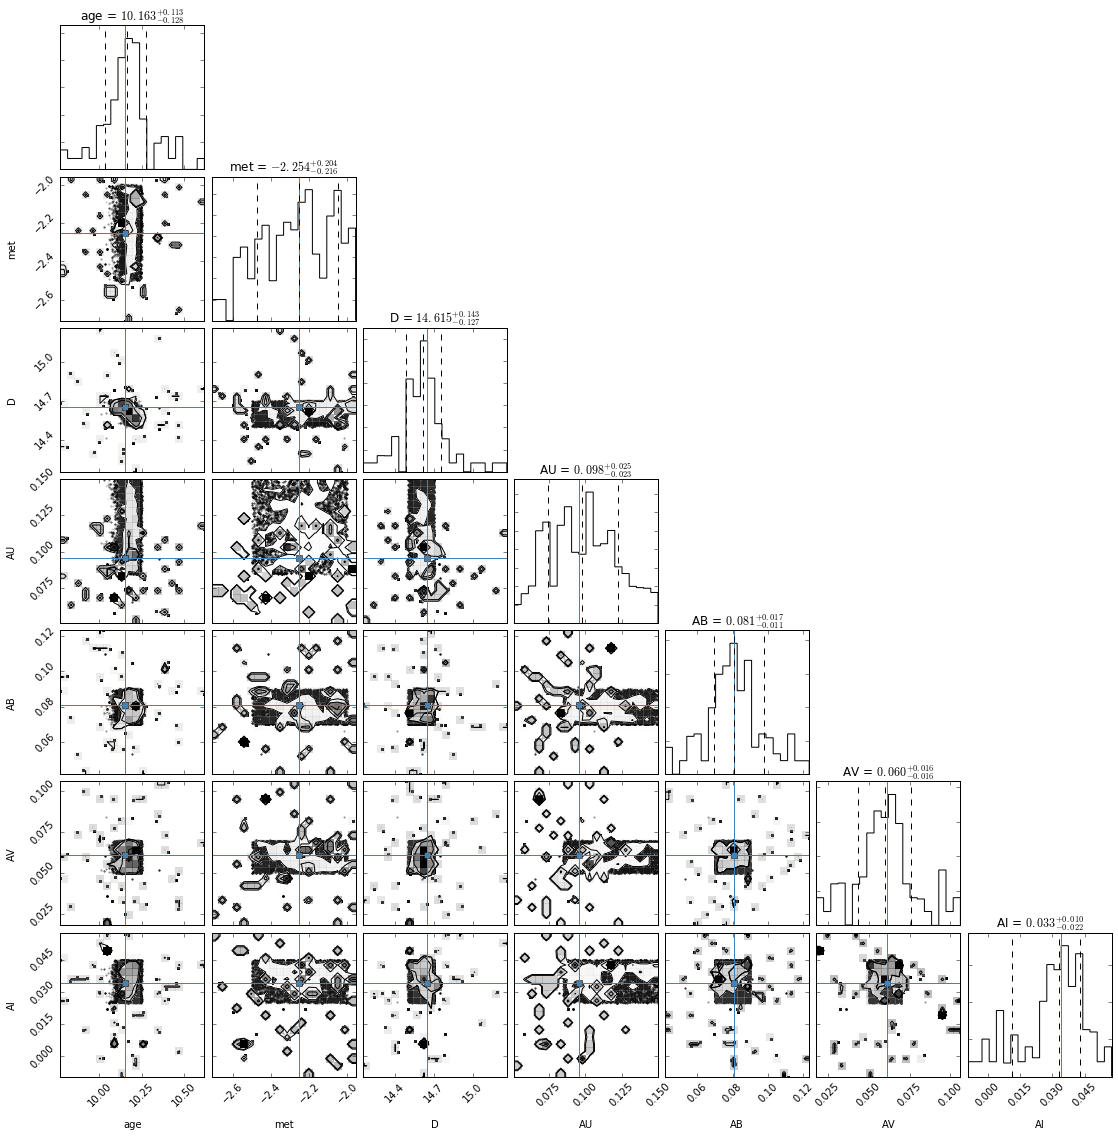

In [228]:
### plots here
emcee_samples = sampler.chain.reshape((-1, ndim))
fig = corner.corner(emcee_samples, labels=["age", "met", "D", "AU", "AB", "AV", "AI"], quantiles=[0.16, 0.5, 0.84], \
                    truths=[10.15, -2.25, 14.65, 0.096, 0.081, 0.061, 0.034], show_titles=True, title_fmt='.3f')
plt.show(fig)

With the addition of more filters, the results seem similar to before. Metallicity is a bit better constrained, but now the extinctions are not as well constrained. 

## Part (e) &mdash; add GALEX FUV filter

Using this plot (https://ned.ipac.caltech.edu/level5/Fitzpatrick/Figures/figure1.gif), I estimate the GALEX FUV extinction at ~150 nm to be about 0.16.

In [229]:
ag = 0.16 # galex fuv extinction

In [230]:
sp = fsps.StellarPopulation(compute_vega_mags=True, sfh=0, zcontinuous=1, logzsol=-2.25) # default sfh=0 corresponds to a SSP
ubvigmags = sp.get_mags(tage=10**(10.15-9.0), bands=['u', 'b', 'v', 'cousins_i', 'galex_fuv'])

In [231]:
u_true = ubvigmags[0] + au + DM
b_true = ubvigmags[1] + ab + DM
v_true = ubvigmags[2] + av + DM
i_true = ubvigmags[3] + ai + DM
g_true = ubvigmags[4] + ag + DM
print u_true, b_true, v_true, i_true, g_true

21.481994324 21.5231443131 21.0048050376 20.1560214927 24.2594031768


In [232]:
### add noise to photometry
u_err = np.random.normal(loc=0, scale=0.1)
b_err = np.random.normal(loc=0, scale=0.1)
v_err = np.random.normal(loc=0, scale=0.1)
i_err = np.random.normal(loc=0, scale=0.1)
g_err = np.random.normal(loc=0, scale=0.1)
u_data = u_true + u_err
b_data = b_true + b_err
v_data = v_true + v_err
i_data = i_true + i_err
g_data = g_true + g_err
print u_data, b_data, v_data, i_data, g_data

21.475989795 21.4076457358 21.1464818721 20.1496773866 24.2720407791


In [243]:
### set up emcee here
# probabilites here
def lnlike(theta, u_data, b_data, v_data, i_data, g_data, err):
    # assumes model SSP already defined in the variable mod_sp
    logage, met, DM, au, ab, av, ai, ag = theta
    mod_sp.params['logzsol'] = met
    ubvig_mod = mod_sp.get_mags(tage=10**(logage-9.0), bands=['u', 'b', 'v', 'cousins_i', 'galex_fuv'])
    u_mod = ubvig_mod[0] + au + DM
    b_mod = ubvig_mod[1] + ab + DM
    v_mod = ubvig_mod[2] + av + DM
    i_mod = ubvig_mod[3] + ai + DM
    g_mod = ubvig_mod[4] + ag + DM
    return -0.5*((v_data-v_mod)**2/err**2 - np.log(1.0/err**2) + \
                 (i_data-i_mod)**2/err**2 - np.log(1.0/err**2) + \
                (u_data-u_mod)**2/err**2 - np.log(1.0/err**2) + \
                (b_data-b_mod)**2/err**2 - np.log(1.0/err**2) + \
                (g_data-g_mod)**2/err**2 - np.log(1.0/err**2))

def lnprior(theta):
    logage, met, DM, au, ab, av, ai, ag = theta
    if 10.0 <= logage <= 10.25 and 14.5 <= DM <= 14.7 and 0.05 <= av <= 0.07 and 0.025 <= ai <= 0.045 and \
    0.085<= au <= 0.15 and 0.07 <= ab <= 0.09 and 0.15 <= ag <= 0.17 and -2.50 <= met <= -2.00:
        return 0.0
    return -np.inf

def lnprob(theta, u_data, b_data, v_data, i_data, g_data , err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, u_data, b_data, v_data, i_data, g_data , err)

In [234]:
### create an FSPS object
mod_sp = fsps.StellarPopulation(compute_vega_mags=True, sfh=0, zcontinuous=1, logzsol=-2.25)

In [244]:
### run emcee here
ndim, nwalkers = 8, 80
pos = [np.random.normal((10.1, -2.3, 14.6, 0.09, 0.08, 0.06, 0.03, 0.16),(0.1,0.1,0.1,0.01,0.01,0.01,0.01,0.01)) \
       for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[u_data, b_data, v_data, i_data, g_data, 0.1])
pos1, prob, state = sampler.run_mcmc(pos, 1000);
sampler.reset()
sampler.run_mcmc(pos1, 2000, rstate0=state);

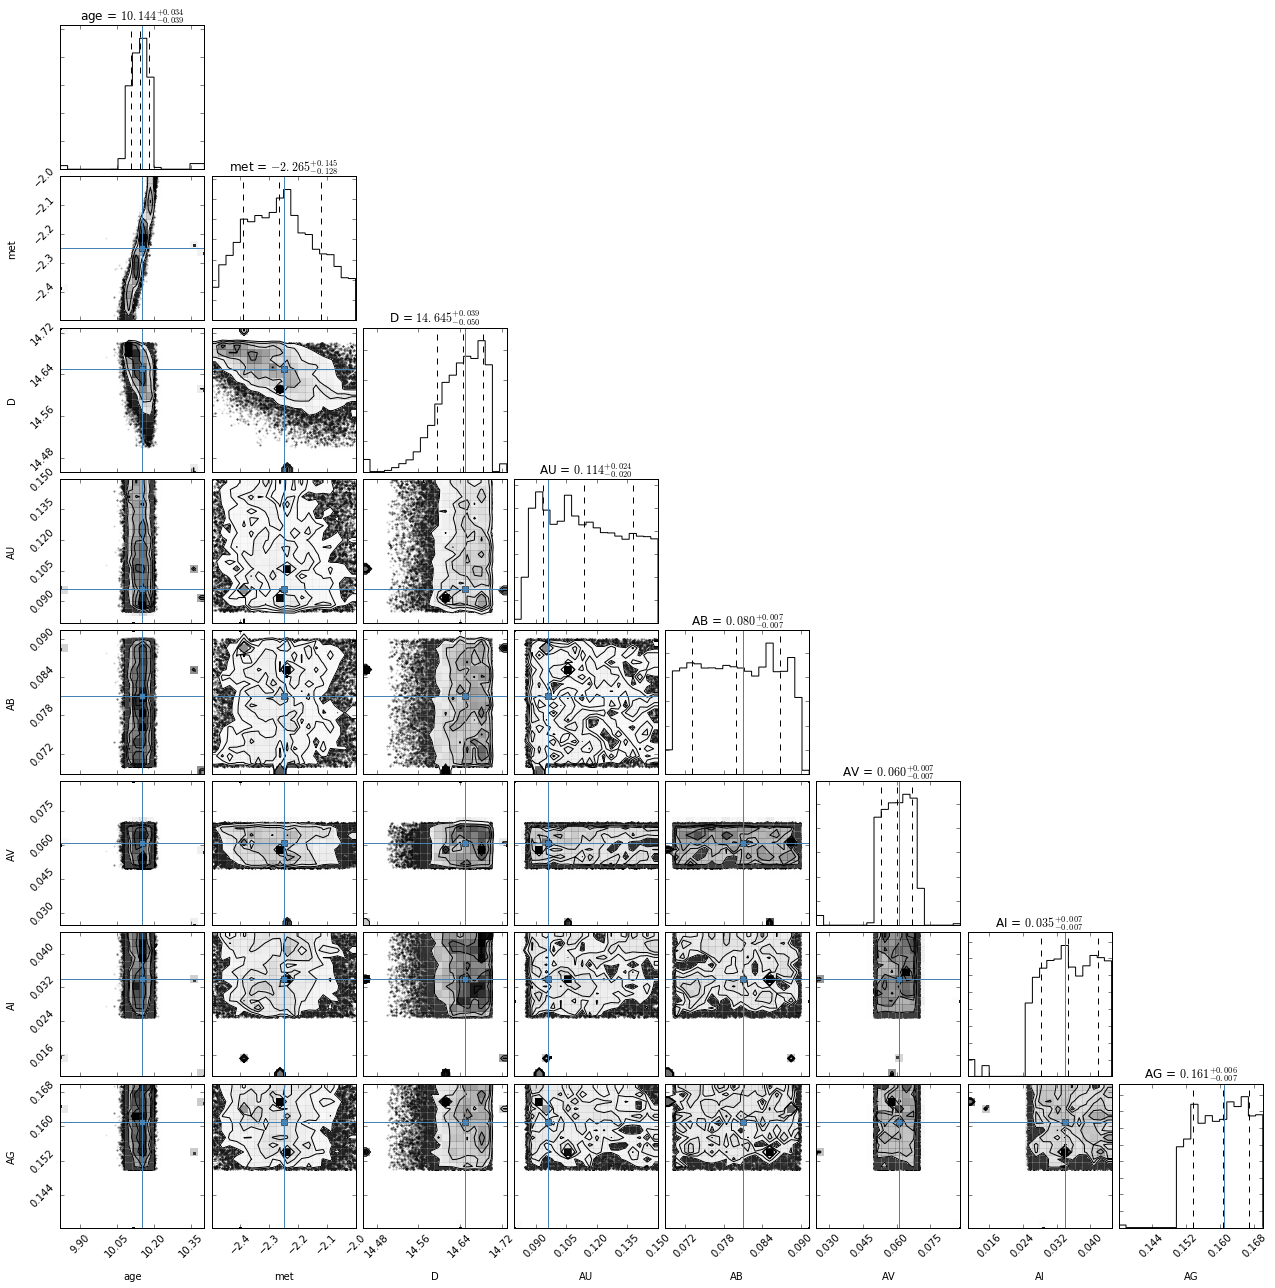

In [245]:
### plots here
emcee_samples = sampler.chain[:,:,:].reshape((-1, ndim))
fig = corner.corner(emcee_samples, labels=["age", "met", "D", "AU", "AB", "AV", "AI", "AG"], \
                    quantiles=[0.16, 0.5, 0.84], \
                    truths=[10.15, -2.25, 14.65, 0.096, 0.081, 0.061, 0.034, 0.161], show_titles=True, \
                    title_fmt='.3f')
plt.show(fig)

I don't really understand what's happening in these plots! :(

Some issues with using UV is that extinction in the UV is much greater than extinction in the other bands. Also, the earth's atmosphere is opaque at UV wavelengths, so can't observe from the ground.

In [248]:
### run emcee here
ndim, nwalkers = 8, 80
pos = [np.random.normal((10.1, -2.3, 14.6, 0.09, 0.08, 0.06, 0.03, 0.16),(0.2,0.2,0.2,0.02,0.02,0.02,0.02,0.02)) \
       for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[u_data, b_data, v_data, i_data, g_data, 0.1])
pos1, prob, state = sampler.run_mcmc(pos, 500);
sampler.reset()
sampler.run_mcmc(pos1, 1000, rstate0=state);

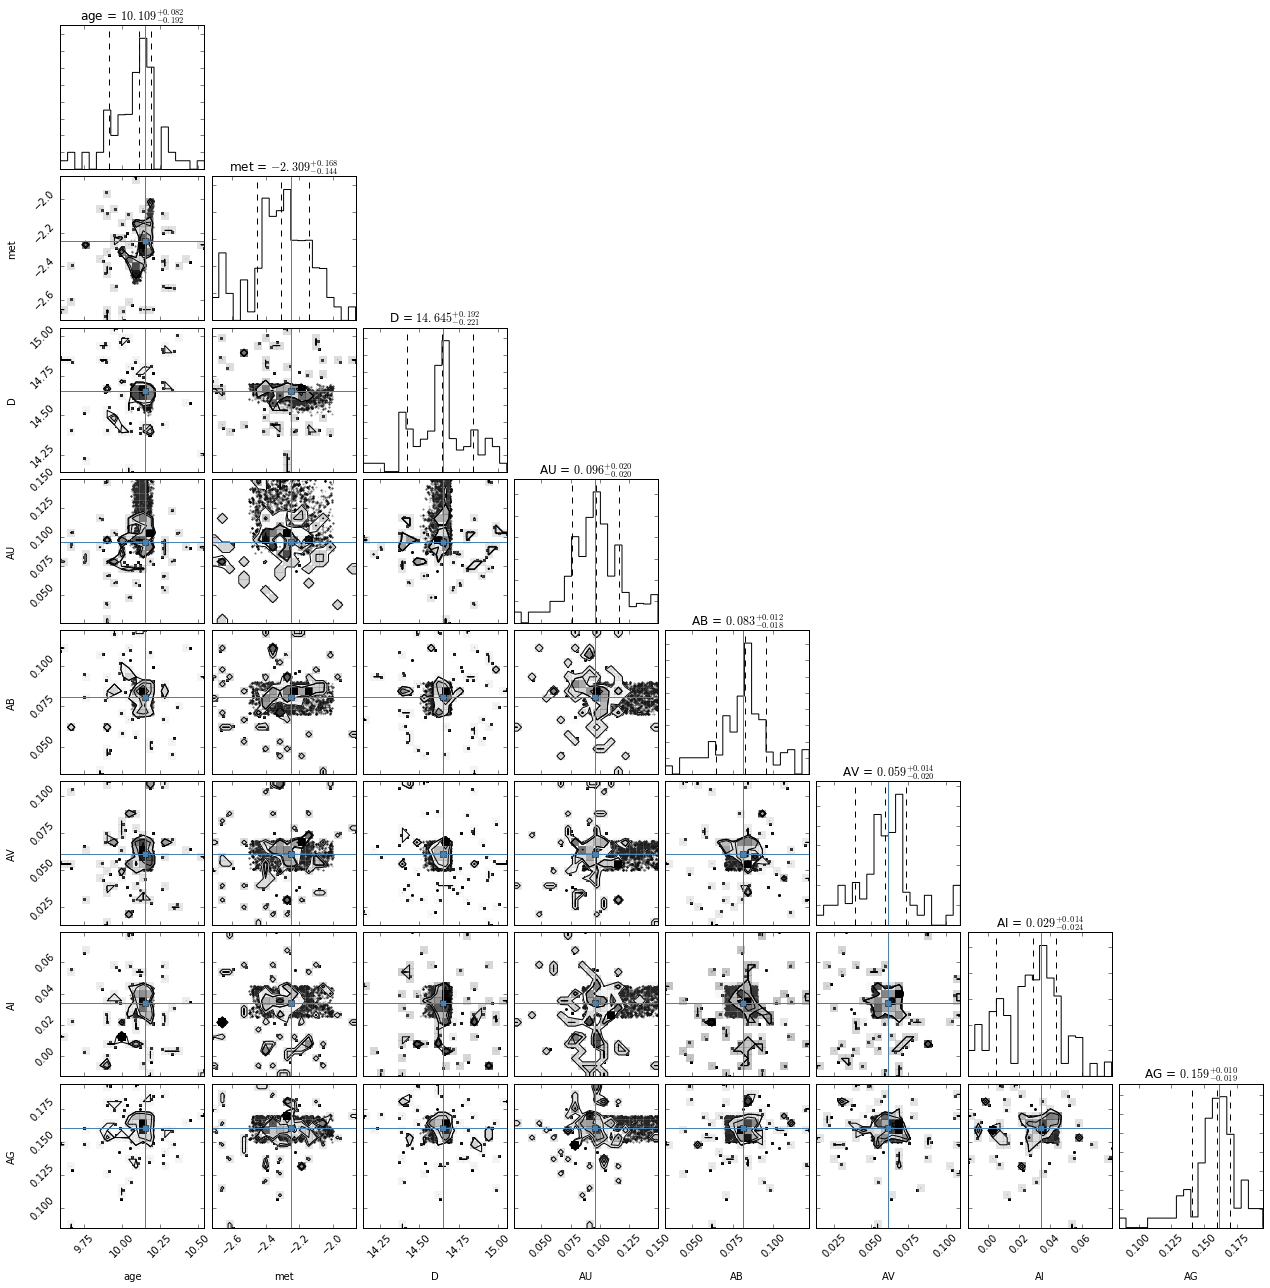

In [249]:
### plots here
emcee_samples = sampler.chain[:,:,:].reshape((-1, ndim))
fig = corner.corner(emcee_samples, labels=["age", "met", "D", "AU", "AB", "AV", "AI", "AG"], \
                    quantiles=[0.16, 0.5, 0.84], \
                    truths=[10.15, -2.25, 14.65, 0.096, 0.081, 0.061, 0.034, 0.161], show_titles=True, \
                    title_fmt='.3f')
plt.show(fig)

I feel like adding the FUV filter should improve the results, although I'm not sure I can see any improvements in the corner plots. Most parameters are close to the "true" values, although uncertainties are still pretty big. It seems like the extinctions are slightly better constrained compared to the UBVI results.